# Results Visualizations for XMI (clean & double snapshots)
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/xmi_mnist_clean", tag="one_snapshot")

In [ ]:
results.update(load_laaos_files("./results/xmi_mnist_clean_double_snapshots", tag="double_snapshot"))

In [ ]:
get_any(results)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,8,1621292074
1,6,1621286684
2,14,1621293068
3,11,1621292710
4,5,1621286163
5,1,1621280258
6,13,1621293126
7,7,1621286723
8,10,1621292245
9,3,1621280267


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

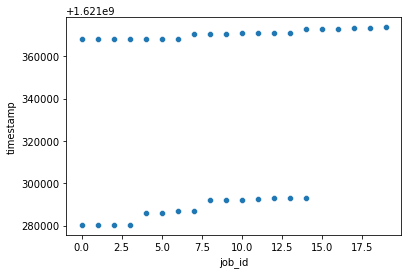

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(25, 35)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

       
    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    num_pool_samples = result.config.num_pool_samples
    
    seed = result.config.seed
    
    snapshot_type = result.tag

    if acquisition_function == "Random":
        acquisition_sizes = [1]
    else:
        acquisition_sizes = [acquisition_size]
        
    if acquisition_function == "Random":
        num_pool_samples = [100]
    else:
        num_pool_samples = [num_pool_samples]
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * result.config.acquisition_size
                < 100
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * result.config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        snapshot_type=snapshot_type,
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        seed=seed,
                    )
                )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,snapshot_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed
0,one_snapshot,BALD,1,100,20,0.5537,12
1,one_snapshot,BALD,1,100,21,0.6340,12
2,one_snapshot,BALD,1,100,22,0.6395,12
3,one_snapshot,BALD,1,100,23,0.6205,12
4,one_snapshot,BALD,1,100,24,0.6218,12
...,...,...,...,...,...,...,...
5510,double_snapshot,BALD,1,100,136,0.9374,15
5511,double_snapshot,BALD,1,100,137,0.9429,15
5512,double_snapshot,BALD,1,100,138,0.9433,15
5513,double_snapshot,BALD,1,100,139,0.9420,15


In [ ]:
df.acquisition_size.unique()

array([1])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby(["acquisition_size", "snapshot_type"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  snapshot_type    acquisition_function
1                 double_snapshot  BALD                    10
                                   CoreSetBALD             10
                  one_snapshot     BALD                     5
                                   CoreSetBALD              5
                                   Random                   5
Name: num_trials, dtype: int64


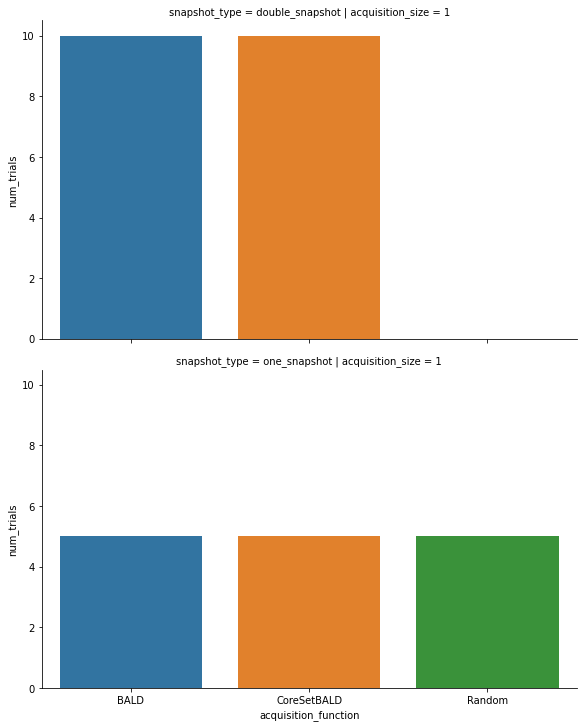

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    row="snapshot_type",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

In [ ]:
df["acq_func_snapshot_type"] = df["acquisition_function"] + " : " + df["snapshot_type"]
df

,snapshot_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy,acq_func_snapshot_type
0,one_snapshot,BALD,1,100,20,0.5537,12,0.5537,BALD : one_snapshot
1,one_snapshot,BALD,1,100,21,0.6340,12,0.6340,BALD : one_snapshot
2,one_snapshot,BALD,1,100,22,0.6395,12,0.6395,BALD : one_snapshot
3,one_snapshot,BALD,1,100,23,0.6205,12,0.6395,BALD : one_snapshot
4,one_snapshot,BALD,1,100,24,0.6218,12,0.6395,BALD : one_snapshot
...,...,...,...,...,...,...,...,...,...
5510,double_snapshot,BALD,1,100,136,0.9374,15,0.9469,BALD : double_snapshot
5511,double_snapshot,BALD,1,100,137,0.9429,15,0.9469,BALD : double_snapshot
5512,double_snapshot,BALD,1,100,138,0.9433,15,0.9469,BALD : double_snapshot
5513,double_snapshot,BALD,1,100,139,0.9420,15,0.9469,BALD : double_snapshot


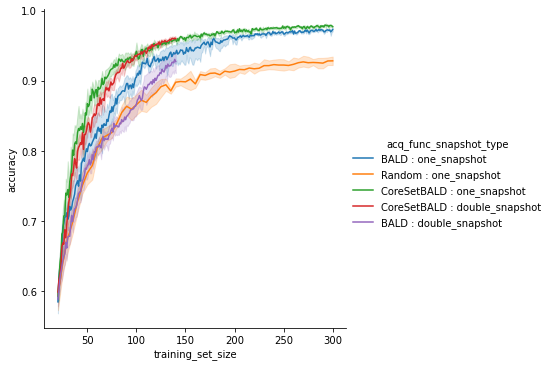

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    #col="acquisition_size",
    #col="xmi_type",
    hue="acq_func_snapshot_type",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function", "snapshot_type"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "snapshot_type", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,snapshot_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy
0,one_snapshot,BALD,1,100,20,0.5537,12,0.5537
1,one_snapshot,BALD,1,100,21,0.6340,12,0.6340
2,one_snapshot,BALD,1,100,22,0.6395,12,0.6395
5,one_snapshot,BALD,1,100,25,0.6877,12,0.6877
6,one_snapshot,BALD,1,100,26,0.6892,12,0.6892
...,...,...,...,...,...,...,...,...
5491,double_snapshot,BALD,1,100,117,0.9352,15,0.9352
5497,double_snapshot,BALD,1,100,123,0.9379,15,0.9379
5500,double_snapshot,BALD,1,100,126,0.9408,15,0.9408
5506,double_snapshot,BALD,1,100,132,0.9420,15,0.9420


In [ ]:
df_max_accuracy["acq_func_snapshot_type"] = df_max_accuracy["acquisition_function"] + " : " + df_max_accuracy["snapshot_type"]
df_max_accuracy

<ipython-input-26-b9a6fdbba06b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_accuracy["acq_func_snapshot_type"] = df_max_accuracy["acquisition_function"] + " : " + df_max_accuracy["snapshot_type"]


,snapshot_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy,acq_func_snapshot_type
0,one_snapshot,BALD,1,100,20,0.5537,12,0.5537,BALD : one_snapshot
1,one_snapshot,BALD,1,100,21,0.6340,12,0.6340,BALD : one_snapshot
2,one_snapshot,BALD,1,100,22,0.6395,12,0.6395,BALD : one_snapshot
5,one_snapshot,BALD,1,100,25,0.6877,12,0.6877,BALD : one_snapshot
6,one_snapshot,BALD,1,100,26,0.6892,12,0.6892,BALD : one_snapshot
...,...,...,...,...,...,...,...,...,...
5491,double_snapshot,BALD,1,100,117,0.9352,15,0.9352,BALD : double_snapshot
5497,double_snapshot,BALD,1,100,123,0.9379,15,0.9379,BALD : double_snapshot
5500,double_snapshot,BALD,1,100,126,0.9408,15,0.9408,BALD : double_snapshot
5506,double_snapshot,BALD,1,100,132,0.9420,15,0.9420,BALD : double_snapshot


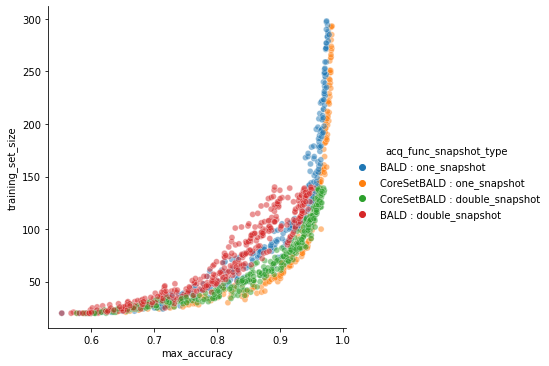

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    #col="xmi_type",
    hue="acq_func_snapshot_type",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "Random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "Random")].groupby(["seed", "acquisition_size", "snapshot_type", "acquisition_function"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "snapshot_type", "acquisition_function"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                                        0.25   0.50    0.75
acquisition_size snapshot_type   acquisition_function                      
1                double_snapshot BALD                  106.0  112.5  126.75
                                 CoreSetBALD            66.5   71.0   73.75
                 one_snapshot    BALD                   88.0   91.0   99.00
                                 CoreSetBALD            55.0   58.0   58.00


In [ ]:
df2 = df[(df.accuracy >= 0.95) & (df.acquisition_function != "Random")].groupby(["seed", "acquisition_size", "acquisition_function",]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function",]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                         0.25   0.50   0.75
acquisition_size acquisition_function                      
1                BALD                  135.00  135.5  136.0
                 CoreSetBALD           114.25  116.5  120.0
